In [1]:
# Parsing ascii files from the eyelink into eye position and data table files
# Clara Kuper, September 2020

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import ipywidgets as widgets
from my_funcs import get_p_in
import math
import os
import re
import remodnav

path_data = '../1_Data/'
path_design = '../1_Design/'
path_edf = '../1_edf/'
path_msg = '../2_msg/'
path_clean = '../2_cleaned/'
path_sac = '../2_sac/'

info = pd.read_csv('../0-1_raw/visual.txt', sep = '\t')

In [2]:
info

,white,black,bgcolor,fgcolor,window,windowRect_1,windowRect_2,windowRect_3,windowRect_4,xCenter,...,targetxPos,rangeAccept,rangeCalib,goalColor_1,goalColor_2,goalColor_3,textColor,attackerColor,targetColor,fixColor
0,1,0,0,1,10,0,0,1920,1080,960,...,1302.901044,274.320835,34.290104,0,0.2,0.8,1,1,1,1


In [3]:
#%%cmd 
#..\1_edf\edf2asc ..\1_edf\AF03_NS.edf

# ..\1_edf\edf2asc ..\1_edf\AA01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AA02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AA03_NS.edf
# ..\1_edf\edf2asc ..\1_edf\ab01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AC01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AC02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AC03_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AD01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AD02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AD03_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AE01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AE02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AE03_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AF01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AF02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AG01_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AG02_NS.edf
# ..\1_edf\edf2asc ..\1_edf\AG03_NS.edf

# we type everything by hand here. sorry

In [4]:
# get the files, this will be set up in a bigger loop later
# open files and read them 
# todo:
# write out every new presentation of a target
# write out all saccade onsets
# find the point when both fixated, set this as trial_start

# next: plot the location of the stimuli
# next: compare timing from eyelink and other data.





files = os.listdir(path_edf)
for file in files:

    # find all ascii files for parsing

    if re.search('.\.asc',file):

        # check if any of these files was already processed:
        # messages are the message events from the edf file
        if os.path.isfile(path_msg+file[:7]+'.csv'):
            print('message file for {} was already parsed, skipping ...'.format(file))
            get_msg = False
        else:
            get_msg = True
        # sac are the raw eye movement files
        if os.path.isdir(path_sac+file[0:4]+'/'):
            print('saccade file for {} was already parsed, skipping ...'.format(file))
            get_sac = False
        else:
            get_sac = True

        if not get_msg and not get_sac:
            print('file completely parsed.')
            continue

        print('Parsing file {}'.format(file))

        #basic information about this file

        subject = file[0:2]
        session = file[2:4]
        # make a new folder for the eye movements for this subject
        path_sub_sac = path_sac + subject+session+'/' 
        if get_sac:
            os.makedirs(path_sub_sac)


        f = open(path_edf+file, 'r')
        l = f.readlines()
        read = False
        #time_start = 4
        #time_end = 12
        l_id = 0

        # read the file till the first block starts (discarding all information before)
        while not read:
            if l[l_id].find('EXPERIMENT START')>=0 or l[l_id].find('EXPERIMENT STARTED')>=0:
                start_id = l_id
                read = True
            l_id += 1

        # set up the tables where we will save the data.
        # there will be two of them, one for the continuous eye position, one for the responses and message timing
        position_data = [] # for eye position data
        events = [] # for time stamps of events
        targets_pos = []
        targets_time = []
        tr_nr = 0 # set the trial number to 0
        block_nr = 0 # set the block number to 0
        tar_y = None
        in_trial = False # we only want the eye position when the trial has started (after trial_start)


        for line in l[start_id:]:

            # additional information for the table
            #append_message = [subject, session, block_nr, tr_nr]

            if line[0:3].isnumeric(): # either the line starts with a number (time stamp), or with a string (message or detected movement)
                    #sample_data = np.hstack((line.split(),append_message))
                    position_data.append(line.split())
                    #position_data.append(sample_data)

            else: 

                if line.find('BLOCK_START')>=0:
                    block = line.find('BLOCK_START')
                    block_nr = str(line.split(',')[1]).split(' ')[1]
                    while len(str(block_nr))<2:
                        block_nr = '0'+str(block_nr)

                if line.find('TRIAL_SYNCTIME')>=0:
                    sync = line.find('TRIAL SYNCTIME')
                    sync_t = int(line.split('\t')[1].split(' ')[0])

                if line.find('TRIAL_ID')>=0:
                    trial_ID = int(line.split(',')[1])

                if line.find('TRIAL_START')>= 0:
                    start = line.find('TRIAL_START')
                    start_t = int(line.split('\t')[1].split(' ')[0])
                    tr_nr = str(line.split(',')[1]).split('\n')[0].split(' ')[1]
                    while len(str(tr_nr)) < 3:
                        tr_nr = '0'+str(tr_nr)
                    tr_tary = []
                    tr_tart = []

                    # set all values to read out to none
                    stim_on = None
                    eyes_fix = None
                    kb_down = None
                    att_moved = None
                    hand_moved = None
                    eyes_moved = None
                    att_dis = None
                    hand_stopped = None
                    eyes_stopped = None
                    att_goal = None
                    feedback_shown = None
                    response_cat = None
                    tar_y = None
                    valid_trial = 1
                    position_data = []

                    in_trial = True

                if line.find('EXPERIMENT_END')>=0:
                    print('end experiment {}'.format(file))
                    break


                if in_trial:

                    if line[0:3]== 'MSG':


                        # get time write to table

                        if line.find('STIM_ON_SCREEN')>=0:
                            stim_on = int(line.split('\t')[1].split(' ')[0])

                        if line.find('EYES_FIXATED')>=0:
                            eyes_fix = int(line.split('\t')[1].split(' ')[0])

                        if line.find('KEYBOARD_DOWN')>=0:
                            kb_down = int(line.split('\t')[1].split(' ')[0])

                        if line.find('BOTH_FIX')>=0:
                            fix_t = int(line.split('\t')[1].split(' ')[0])

                        if line.find('ATTACKER_MOVED')>=0:
                            att_moved = int(line.split('\t')[1].split(' ')[0])

                        if line.find('NEW_TARGET')>=0:
                            line_parsed = line.split('y: ')
                            tar_y = int(line_parsed[1])
                            tr_tary.append(tar_y)
                            tar_t = int(line.split('\t')[1].split(' ')[0])
                            tr_tart.append(tar_t)

                        if line.find('START_HAND_MOVEMENT')>=0:
                            hand_moved = int(line.split('\t')[1].split(' ')[0])

                        if line.find('EYES_START')>=0:
                            eyes_moved = int(line.split('\t')[1].split(' ')[0])

                        if line.find('ATTACKER_DISAPPEARED')>=0:
                            att_dis = int(line.split('\t')[1].split(' ')[0])

                        if line.find('EYES_END')>=0:
                            eyes_stopped = int(line.split('\t')[1].split(' ')[0])

                        if line.find('END_HAND_MOVEMENT')>=0:
                            hand_stopped = int(line.split('\t')[1].split(' ')[0])

                        if line.find('ATTACKER_REACHED_GOAL')>=0:
                            att_goal = int(line.split('\t')[1].split(' ')[0])

                        if line.find('FEEDBACK_PRESENTED')>=0:
                            feedback_shown = int(line.split('\t')[1].split(' ')[0])

                        if line.find('FIXATION_BREAK')>= 0:
                            valid_trial = 0

                        if line.find('RESPONSE_TRIAL')>=0:
                            line_parsed = line.split(', ')
                            response_cat = line_parsed[-1]
                            response_cat = response_cat[0:-1]

                        if line.find('SUCCESS')>=0:
                            success = line.split(' ')[2][0]
                            valid_trial = success

                        if line.find('TRIAL_END')>=0:
                            end_t = int(line.split('\t')[1].split(' ')[0])
                            f_sub_sac = str(block_nr)+str(tr_nr)
                            eye_move_file = path_sub_sac+f_sub_sac+'.csv'

                            trial_events = [trial_ID, subject, session, block_nr, tr_nr, start_t, sync_t, fix_t, stim_on, eyes_fix, kb_down, att_moved, 
                                            eyes_moved, hand_moved, att_dis, eyes_stopped, hand_stopped, att_goal, feedback_shown, end_t,
                                            response_cat, valid_trial, eye_move_file]

                            events.append(trial_events) # for events
                            targets_pos.append(tr_tary)
                            targets_time.append(tr_tart)

                            if get_sac:
                                eye_position = pd.DataFrame(position_data, columns = ['time', 'x_pos', 'y_pos', 'pupil', 'right'])
                                eye_position.x_pos[eye_position.x_pos=='.'] = np.nan
                                eye_position.y_pos[eye_position.y_pos=='.'] = np.nan
                                eye_position.pupil[eye_position.pupil=='.'] = np.nan 
                                eye_position.to_csv(eye_move_file, sep = ',', index=False)

                                # to be accessible to remodnav, the file should start with x and y coordinates and should not have a header
                                remod_file = eye_position.iloc[:,1:3]
                                remod_file.to_csv(path_sub_sac+f_sub_sac+'.tsv', sep = '\t', index=False, header=False)


                            in_trial = False

        # save the files

        if get_msg:
            event_data = pd.DataFrame(events, columns = ['id','subject', 'session' ,'block', 'trial', 'start_t', 'sync', 'fix', 'stim_on', 'eyes_fix', 
                                                         'kb_down', 'att_moved', 'eyes_moved', 'hand_moved', 'att_dis', 'eyes_stopped',
                                                         'hand_stopped', 'att_goal', 'feedback_shown', 'end_t', 'response_cat', 'valid', 'eye_pos'])


            try:
                target_data = pd.DataFrame(targets_pos, columns =['ty_1', 'ty_2', 'ty_3', 'ty_4', 'ty_5', 'ty_6'])
                target_timing = pd.DataFrame(targets_time, columns =['tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5', 'tt_6'])
            except:
                target_data = pd.DataFrame(targets_pos, columns =['ty_1', 'ty_2', 'ty_3', 'ty_4', 'ty_5', 'ty_6', 'ty_7'])
                target_timing = pd.DataFrame(targets_time, columns =['tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5', 'tt_6', 'tt_7'])


            full_df = pd.concat([event_data,target_data,target_timing], axis = 1)
            full_df.to_csv(path_msg+file[:7]+'.csv', sep = ',', index=False)



        print('Successfully parsed file {}'.format(file))


print('Done')

message file for AD01_NS.asc was already parsed, skipping ...
saccade file for AD01_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AD02_NS.asc was already parsed, skipping ...
saccade file for AD02_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AD03_NS.asc was already parsed, skipping ...
saccade file for AD03_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AE01_NS.asc was already parsed, skipping ...
saccade file for AE01_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AE02_NS.asc was already parsed, skipping ...
saccade file for AE02_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AE03_NS.asc was already parsed, skipping ...
saccade file for AE03_NS.asc was already parsed, skipping ...
file completely parsed.
message file for AF01_NS.asc was already parsed, skipping ...
saccade file for AF01_NS.asc was already parsed, s

In [5]:
# load some information from the design file
# write this out here, copy to cell below (to perform the actual detection)
tracker_samples = 1000
dpp = 1/info.ppd

print(dpp)

0    0.029163
Name: ppd, dtype: float64


In [6]:
#%%cmd
#cd ../2_sac/AF03/
#for /R %f in (*.tsv) do (remodnav "%f" "%f_parsed.tsv" 0.0291 1000.0)

In [7]:
# once all data is preprocessed, we want to combine all data in one file
# define a load all function

def load_all(directory, sort_id = False):
    
    files = os.listdir(directory)
    first_loaded = False
    
    for file in files:
        if re.search('.\.csv',file):
            df = pd.read_csv(directory+file)
            try:
                df.subject
            except:
                df['subject'] = file[0:2]
                
            try:
                df.session
            except:
                df['session'] = file[2:4]
                
            if sort_id:
                df = df.sort_values('id', ignore_index = True)
                
            print('loaded {}'.format(file))
            if file == 'AA01_NS.csv':
                df = df[df.block!=8]
                
            if not first_loaded:
                all_files = df
                first_loaded = True

            else:
                all_files = pd.concat([df,all_files])
            
    return all_files

In [8]:
# load all the eye movement files and save them in one file
# loop through and save all parsed eye movement files
def loop_through_em(directory, path):
    sub = directory.split('/')[2][0:2]
    ses = directory.split('/')[2][2:4]
    print('loading subject {}, session {}'.format(sub,ses))
    files = os.listdir(path+directory)
    first_loaded = False
    
    for f in files:
        if re.search('.tsv_parsed\.tsv',f):
            blo = f[0:2]
            tri = f.split('.')[0][2:]
            df = pd.read_csv(directory+'/'+f, sep = '\t')
            
            df['trial'] = int(tri)
            df['block'] = int(blo)
            df['session'] = int(ses)
            df['subject'] = sub
            
            if not first_loaded:
                df_out = df
                first_loaded = True
            else:
                df_out = pd.concat([df_out,df])
                
    df_out = df_out.sort_values(['block', 'trial'])
    df_out.to_csv(path+sub+ses+'.csv', sep = ',', index = False)
    

# for folder in os.listdir(path_sac):
#     if os.path.isfile(path_sac+folder):
#         pass
#     else:
#         loop_through_em(path_sac+folder, path_sac)

In [9]:
# load all message files
if os.path.isfile(path_msg+'messages.csv'):
    print('The message file was already generated, loading now')
    messages = pd.read_csv(path_msg+'messages.csv')   
else:
    messages = load_all(path_msg, sort_id = False)
    messages.to_csv(path_msg+'messages.csv', sep = ',', index = False)

# load all relevant data files
if os.path.isfile(path_data+'all_data.csv'):
    print('The data file was already generated, loading now')
    data = pd.read_csv(path_data+'all_data.csv')
else:
    data = load_all(path_data, sort_id = False)
    data.to_csv(path_data+'all_data.csv', sep = ',', index = False)  

# load all relevant design files
if os.path.isfile(path_design+'all_design.csv'):
    print('The design file was already generated, loading now')
    design = pd.read_csv(path_design+'all_design.csv')
else:
    design = load_all(path_design, sort_id = False)
    design.to_csv(path_design+'all_design.csv', sep = ',', index = False)


# load all eye movement files
if os.path.isfile(path_sac+'all_em.csv'):
    print('The eye movement file was already generated, loading now')
    movements = pd.read_csv(path_sac+'all_em.csv')
else:
    movements = load_all(path_sac)
    movements.to_csv(path_sac+'all_em.csv', sep = ',', index = False)

print('Done')

The message file was already generated, loading now
The data file was already generated, loading now
The design file was already generated, loading now
The eye movement file was already generated, loading now
Done


In [10]:
messages = pd.read_csv(path_msg+'messages.csv')
data = pd.read_csv(path_data+'all_data.csv')
design = pd.read_csv(path_design+'all_design.csv')
movements = pd.read_csv(path_sac+'all_em.csv')

In [11]:
# save the message, data and design files, in case we accidentally change them
# set all files to the same order
messages_old = messages.copy()
messages.sort_values(['subject', 'session', 'id'], inplace = True)
messages.reset_index(drop = True, inplace = True)

data_old = data.copy()
data.sort_values(['subject', 'session', 'id'], inplace = True)
data.reset_index(drop = True, inplace = True)

design_old = design.copy()
design.sort_values(['subject', 'session', 'id'], inplace = True)
design.reset_index(drop = True, inplace = True)

em_old = movements.copy()
movements.sort_values(['subject', 'session', 'block', 'trial'], inplace = True)
movements.reset_index(drop = True, inplace = True)

In [12]:
# the three data frames should all have the same length
print(design.shape)
print(data.shape)
print(messages.shape)
print(movements.shape)

(10454, 17)
(10454, 25)
(10454, 45)
(152941, 15)


In [13]:
# not all messages register when a trial was invalid. We correct that here
messages.loc[np.where(data.success.values != messages.valid.values)[0],'valid'] = 0

In [14]:
#concatenate all data, messages and design into one df
if (design.subject == data.subject).all():
    design.drop('subject',axis = 1, inplace = True)
if (design.session == data.session).all():
    design.drop('session', axis = 1, inplace = True)
if (design.id == data.id).all():
    design.drop('id', axis = 1, inplace = True)
big_df = pd.concat([design, data], axis = 1)
big_df

#remove duplicate columns
big_df

,goalPos,difficulty,in_out,up_down,posSet_1,posSet_2,posSet_3,posSet_4,posSet_5,posSet_6,...,t_feedback,t_end,goResp,hitGoal,goalY,attackerY,touchX,touchY,subject,session
0,0,1.818176,-1,-1,0.620495,0.496186,-1.910110,2.412064,1.578577,-2.021614,...,2874.490588,2874.490588,0,1,540.000000,-74.814990,NaN,NaN,AD,1
1,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,2881.806529,2881.806529,1,0,608.580209,-130.644429,1310.396476,491.616073,AD,1
2,4,1.900498,-1,1,4.910860,6.820707,2.479212,1.935187,2.233964,4.223298,...,2883.614689,2883.614689,0,1,677.160418,209.152565,NaN,NaN,AD,1
3,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,2887.856448,2887.856448,1,1,608.580209,-5.231568,1293.480176,605.675778,AD,1
4,0,1.935859,1,-1,-1.639190,2.108175,1.529668,-1.347691,-3.407911,0.621780,...,2889.673339,2889.673339,0,0,540.000000,-203.541229,NaN,NaN,AD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10449,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,2374.353884,2374.353884,1,1,608.580209,137.773437,1333.533608,632.242513,AG,3
10450,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,2376.337202,2376.337202,1,1,677.160418,65.122184,1307.093339,602.352082,AG,3
10451,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,2378.320558,2378.320558,1,1,540.000000,69.893305,1262.507787,591.424397,AG,3
10452,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,2380.353926,2380.353926,1,1,471.419791,5.324072,1308.130212,551.891892,AG,3


In [15]:
#concatenate all data, messages and design into one df
if (big_df.subject == messages.subject).all():
    messages.drop('subject',axis = 1, inplace = True)
if (big_df.session == messages.session).all():
    messages.drop('session', axis = 1, inplace = True)
if (big_df.id == messages.id).all():
    messages.drop('id', axis = 1, inplace = True)
pd.concat([big_df, messages], axis = 1)

big_df = pd.concat([big_df,messages], axis = 1)
big_df

,goalPos,difficulty,in_out,up_down,posSet_1,posSet_2,posSet_3,posSet_4,posSet_5,posSet_6,...,tt_2,tt_3,tt_4,tt_5,tt_6,tt_7,tt_8,tt_9,tt_10,tt_11
0,0,1.818176,-1,-1,0.620495,0.496186,-1.910110,2.412064,1.578577,-2.021614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,2745249.0,2745416.0,2745582.0,2745749.0,2745916.0,2746082.0,NaN,NaN,NaN,NaN
2,4,1.900498,-1,1,4.910860,6.820707,2.479212,1.935187,2.233964,4.223298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,2751299.0,2751466.0,2751632.0,2751799.0,2751966.0,2752132.0,NaN,NaN,NaN,NaN
4,0,1.935859,1,-1,-1.639190,2.108175,1.529668,-1.347691,-3.407911,0.621780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10449,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,2278767.0,2278934.0,2279101.0,2279267.0,2279434.0,2279601.0,NaN,NaN,NaN,NaN
10450,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,2280751.0,2280918.0,2281084.0,2281251.0,2281417.0,2281584.0,NaN,NaN,NaN,NaN
10451,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,2282734.0,2282901.0,2283067.0,2283234.0,2283401.0,2283567.0,NaN,NaN,NaN,NaN
10452,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,2284767.0,2284934.0,2285101.0,2285267.0,2285434.0,2285601.0,NaN,NaN,NaN,NaN


In [16]:
# clean df: exclude all trials that are not valid
inval_df = big_df[big_df.success == 0]
df = big_df[big_df.success == 1]

#sanity check: is the sum of valid and invalid trial equal to all trials?
print('The data frame has the correct length: ')
print(len(inval_df) + len(df)  == len(big_df))

# clean eye movement files:
# take all invalid rows
for row in inval_df.index:
    
    # write out information about invalid rows
    trial = inval_df.trial[row]
    block = inval_df.block[row]
    session = inval_df.session[row]
    subject = inval_df.subject[row]
    
    # find the rows in eye_movements that belong to this trial
    id_trial = np.where(movements.trial == trial)[0]
    id_block = np.where(movements.block == block)[0]
    id_session = np.where(movements.session == session)[0]
    id_subject = np.where(movements.subject == subject)[0]
    
    # find the index to these locations
    key = np.intersect1d(np.intersect1d(id_trial, id_block),np.intersect1d(id_session, id_subject))
    idx = movements.iloc[key,:].index
    
    # kick out the movements we don't need
    movements.drop(idx, axis = 0, inplace = True)

The data frame has the correct length: 
True


In [17]:
pre_sync_df = df.copy()

In [18]:
df.shape

(9600, 81)

Sanitiy check: The difference between the parsed eyelink data and the data from the experiment should be minimal

In [19]:
# these times are not synchronized, because we may need them to access the raw eye movement files
msg_sync = df.start_t.copy()
dat_sync = df.t_start.copy()

if (df.sync > 1).all():
    # normalize timing in messages
    df.sync -= msg_sync
    df.fix -= msg_sync
    df.stim_on -= msg_sync
    df.eyes_fix -= msg_sync 
    df.att_moved -= msg_sync
    #df.eyes_moved -= msg_sync
    df.hand_moved -= msg_sync
    df.att_dis -= msg_sync
    #df.eyes_stopped -= msg_sync
    df.hand_stopped -= msg_sync
    df.att_goal -= msg_sync
    df.feedback_shown -= msg_sync
    df.kb_down -= msg_sync
    df.end_t -= msg_sync
    
    df.tt_1 -= msg_sync
    df.tt_2 -= msg_sync
    df.tt_3 -= msg_sync
    df.tt_4 -= msg_sync
    df.tt_5 -= msg_sync
    df.tt_6 -= msg_sync
    df.tt_7 -= msg_sync

C:\Users\ClaraQ\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
# normalize and compare timing over messages and data
if (df.initPixx > 1).all():
    df.initPixx -= dat_sync
    df.t_draw -= dat_sync
    df.t_kbdown -= dat_sync
    df.t_eyesfixed -= dat_sync 
    df.t_bothfixed -= dat_sync
    df.t_go -= dat_sync
    df.t_disap -= dat_sync
    #df.t_eyesStart -= dat_sync
    df.t_movStart -= dat_sync
    #df.t_eyesEnd -= dat_sync
    df.t_movEnd -= dat_sync
    df.t_cross -= dat_sync
    df.t_feedback -= dat_sync
    df.t_end -= dat_sync

In [21]:
# find differences between ms and data

stim_on_screen = df.stim_on/1000 - df.t_draw
eyes_fixates = df.eyes_fix/1000 - df.t_eyesfixed
attacker_moved = df.att_moved/1000 - df.t_go
hand_moved = df.hand_moved/1000 - df.t_movStart
hand_landed = df.hand_stopped/1000 - df.t_movEnd
trial_over = df.att_goal/1000 - df.t_cross

C:\Users\ClaraQ\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ClaraQ\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


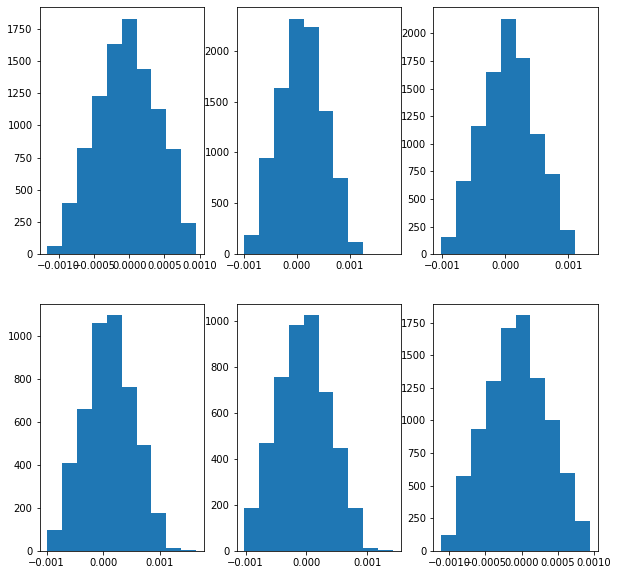

In [22]:
# plot them all
fig1, axs1 = plt.subplots(2,3, figsize = (10,10))

axs1[0,0].hist(stim_on_screen)
axs1[0,1].hist(eyes_fixates)
axs1[0,2].hist(attacker_moved)
axs1[1,0].hist(hand_moved)
axs1[1,1].hist(hand_landed)
axs1[1,2].hist(trial_over);


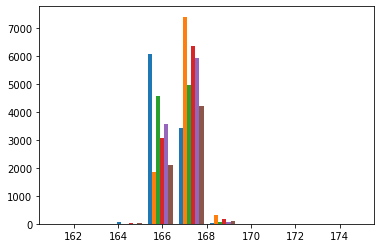

In [23]:
# Sanity check 2: Was the presentation of targets regular?
target_t_col = ['tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5', 'tt_6', 'tt_7']
targets_t = df[target_t_col]
plt.hist(np.diff(targets_t));

Additional possible cleaning steps here:
    1. Remove trials with too big deviation between eyelink and matlab
    2. Remove trials with unclean timing in target presentation
    
To, from visual inspection, this looks good and I would keep this as it is.

From here on, we will work with the data collected from the eyelink

In [24]:
# save the data file at this point
df_with_data = df
#df_with_data.to_csv(path_clean+'df_cleaned.csv', sep = ',', index = False)

em_cleaned = movements
#em_cleaned.to_csv(path_clean+'em_cleaned.csv', sep = ',', index = False)

In [25]:
df_with_data

,goalPos,difficulty,in_out,up_down,posSet_1,posSet_2,posSet_3,posSet_4,posSet_5,posSet_6,...,tt_2,tt_3,tt_4,tt_5,tt_6,tt_7,tt_8,tt_9,tt_10,tt_11
1,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,1368.0,1535.0,1701.0,1868.0,2035.0,2201.0,NaN,NaN,NaN,NaN
3,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,1298.0,1465.0,1631.0,1798.0,1965.0,2131.0,NaN,NaN,NaN,NaN
5,2,1.929658,-1,1,3.746282,0.868587,-1.166560,-1.477911,1.467197,5.791083,...,1116.0,1283.0,1449.0,1616.0,1783.0,1950.0,NaN,NaN,NaN,NaN
7,-2,1.834521,-1,-1,-3.330029,-0.337660,0.971259,1.627050,-5.873847,1.302279,...,809.0,976.0,1143.0,1309.0,1476.0,1643.0,NaN,NaN,NaN,NaN
9,4,1.920750,1,1,4.869227,3.625997,5.868832,5.287595,5.330901,2.434693,...,1054.0,1221.0,1388.0,1554.0,1721.0,1888.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10449,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,942.0,1109.0,1276.0,1442.0,1609.0,1776.0,NaN,NaN,NaN,NaN
10450,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,876.0,1043.0,1209.0,1376.0,1542.0,1709.0,NaN,NaN,NaN,NaN
10451,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,843.0,1010.0,1176.0,1343.0,1510.0,1676.0,NaN,NaN,NaN,NaN
10452,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,921.0,1088.0,1255.0,1421.0,1588.0,1755.0,NaN,NaN,NaN,NaN


In [26]:
df = df_with_data.copy()
movements = em_cleaned.copy()

In [27]:
# remove duplicates

data_col = ['initPixx', 't_start', 't_draw', 't_kbdown', 't_eyesfixed',
       't_bothfixed', 't_go', 't_disap', 't_movStart', 't_movEnd', 't_cross', 
            't_feedback', 't_end', 'tt_7', 'tt_8', 'tt_9', 'tt_10', 'tt_11', 'ty_7', 'ty_8', 'ty_9', 'ty_10',
            'ty_11', 'posSet_7', 'posSet_8', 'valid', 'success']
        # 't_eyesStart', 't_eyesEnd', 

df.drop(data_col, axis = 1, inplace = True)

In [28]:
df.columns

Index(['goalPos', 'difficulty', 'in_out', 'up_down', 'posSet_1', 'posSet_2',
       'posSet_3', 'posSet_4', 'posSet_5', 'posSet_6', 'fixT', 'attackerYPos',
       'id', 'rea_time', 'mov_time', 'goResp', 'hitGoal', 'goalY', 'attackerY',
       'touchX', 'touchY', 'subject', 'session', 'block', 'trial', 'start_t',
       'sync', 'fix', 'stim_on', 'eyes_fix', 'kb_down', 'att_moved',
       'eyes_moved', 'hand_moved', 'att_dis', 'eyes_stopped', 'hand_stopped',
       'att_goal', 'feedback_shown', 'end_t', 'response_cat', 'eye_pos',
       'ty_1', 'ty_2', 'ty_3', 'ty_4', 'ty_5', 'ty_6', 'tt_1', 'tt_2', 'tt_3',
       'tt_4', 'tt_5', 'tt_6'],
      dtype='object')

In [29]:
# synchronize timing, everything is time-centered on the onset of the movement

timing_cols = ['start_t', 'sync', 'fix', 'stim_on', 'eyes_fix', 'kb_down', 'att_moved', 'eyes_moved',
               'hand_moved', 'att_dis', 'eyes_stopped', 'hand_stopped', 'att_goal', 'feedback_shown', 
               'end_t', 'tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5', 'tt_6']
#
sync = df.att_moved.copy()
df['attackermoveMsAbs'] = sync.copy()

for col in timing_cols:
    df[col] -= sync
    #df[col] = df[col]/1000

In [30]:
# synchronize all eye movements to attacker movement onset
for row in df.index:
    
    # write out information about invalid rows
    trial = df.trial[row]
    block = df.block[row]
    session = df.session[row]
    subject = df.subject[row]
    
    # find the rows in eye_movements that belong to this trial
    id_trial = np.where(movements.trial == trial)[0]
    id_block = np.where(movements.block == block)[0]
    id_session = np.where(movements.session == session)[0]
    id_subject = np.where(movements.subject == subject)[0]
    
    # find the index to these locations
    key = np.intersect1d(np.intersect1d(id_trial, id_block),np.intersect1d(id_session, id_subject))
    idx = movements.iloc[key,:].index
    
    # kick out the movements we don't need
    movements.onset[idx] -= df.attackermoveMsAbs[row]/tracker_samples

C:\Users\ClaraQ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# save the movements
em_before_onset = movements.copy()

In [32]:
# remove all eye movements with an onset before the attacker moved
key_pos = np.where(movements.onset>=0)[0]
key_neg = np.where(movements.onset<0)[0]
movements_negative = movements.iloc[key_neg,:]
movements = movements.iloc[key_pos,:]

# remove all eye movements with an onset after the trial was over
key_in_trial = np.where(movements.onset<=1)[0]
movements = movements.iloc[key_in_trial,:]

C:\Users\ClaraQ\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ClaraQ\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


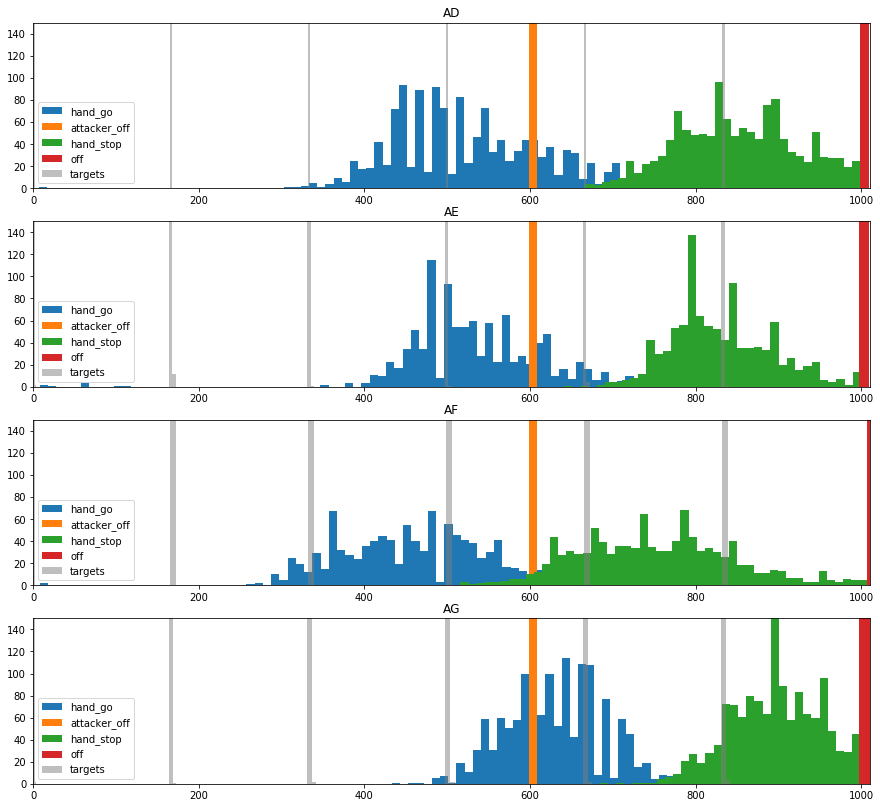

In [33]:
# another visual data set: check the distribution of some important variables relative to the go signal
subjects = np.unique(movements.subject)
fig2,axs2 = plt.subplots(len(subjects),1, figsize = (15,14))

for plt_id, subject in enumerate(subjects):
    #print(subject)
    data = df[df.subject == subject]
    #print(data)
    t = 2
    tt_bin = math.ceil((data.tt_1.max() - data.tt_1.min())/t)

    h = 10
    hand_on_bin = math.ceil((data.hand_moved.max() - data.hand_moved.min())/h)
    hand_off_bin = math.ceil((data.hand_stopped.max() - data.hand_stopped.min())/h)

    a_bin = tt_bin


    axs2[plt_id].set_xlim(-0.1, 1011)
    axs2[plt_id].set_ylim(0, 150)
    #axs2.hist(dff.fix, label = 'fix')
    #axs2.hist(dff.stim_on, label = 'on')
    axs2[plt_id].hist(data.hand_moved, label = 'hand_go', bins = hand_on_bin)
    axs2[plt_id].hist(data.att_dis, label = 'attacker_off', bins = a_bin)
    axs2[plt_id].hist(data.hand_stopped, label = 'hand_stop', bins = hand_off_bin)
    axs2[plt_id].hist(data.att_goal, label = 'off', bins = a_bin)
    axs2[plt_id].hist(data.tt_1, bins = tt_bin, alpha = 0.5, color = 'grey', label = 'targets')
    axs2[plt_id].hist(data.tt_2, bins = tt_bin, alpha = 0.5, color = 'grey')
    axs2[plt_id].hist(data.tt_3, bins = tt_bin, alpha = 0.5, color = 'grey')
    axs2[plt_id].hist(data.tt_4, bins = tt_bin, alpha = 0.5, color = 'grey')
    axs2[plt_id].hist(data.tt_5, bins = tt_bin, alpha = 0.5, color = 'grey')
    axs2[plt_id].hist(data.tt_6, bins = tt_bin, alpha = 0.5, color = 'grey')
    axs2[plt_id].legend(loc = 'lower left')
    axs2[plt_id].set_title(subject)

plt.savefig('../3_Figures/Response_Distribution.png')

In [34]:
# Cleaning step here: Exclude all trials with too fast hand movements
# criterion: how many sds above_below standart are allowed?

criterion = 3
sd = np.std(df.hand_moved)
ok_range = criterion * sd
low = np.mean(df.hand_moved)-ok_range
exclude = np.where(df.hand_moved<=low)[0]

fast_df = df.iloc[exclude,:]
fast_dx = df.iloc[exclude,:].index
df.drop(fast_dx, axis = 0, inplace = True)

In [35]:
# clean the names for all variables

# create new names. all the column names will be in the schema: objectFeatureUnitRelativeto(_number)
# sample positions in dva, relative to the attacker

df_rename = df.copy()

# other name translations
names = {
    'goalPos':'goalPosDegCen', # the y position of the goal in dva, relative to the screen center
    'goalY':'goalPosPixCen', # the y position of the goal in pixel, relative to the screen center
    'attackerYPos':'attackerPosDegCen', # the y position of the attacker in dva, relative to the screen center
    'attackerY':'attackerPosPixCen', # the y position of the attacker in pixel, relative to the screen center
    'touchX': 'touchXPosPixCen', # the X touch coordinate in pixel relative to the screen center
    'touchY': 'touchYPosPixCen', # the Y touch coordinate in pixel relative to the screen center
    'fixT': 'fixDurMs', # the enforced fixation duration in ms
    'start_t': 'startTimeMsAbs', # the time when the trial started in ms, counted from the beginning
    'sync': 'startTimeMsGo', # the time when the trial started in ms, relative to the "go" signal (will be negative)
    'stimOn': 'stimdrawnTimeMsGo',  # the time when the first stimuli were on the screen in ms, relative to the "go" signal (will be negative)
    'eyes_fix': 'eyefixTimeMsGo', # the time when eyes were on their fixation position in ms, relative to the "go" signal (will be negative)
    'kb_down': 'handfixTimeMsGo', # the time when the hand was on the fixation position in ms, relative to the "go" signal (will be negative)
    'fix': 'fixTimeMsGo', # the time hands and eyes where on their fixation position in ms, relative to the "go" signal (will be negative)
    'att_moved': 'attackermoveTimeMsGo', # the time when the attacker started to move in ms this is the go signal (will be zero)
    'eyes_moved': 'eyesmoveTimeMsGo', # the time when the eyes left the fixation area in ms relative to the "go" signal 
    'hand_moved': 'handmoveTimeMsGo', # the time when the hand left the fixation area in ms relative to the "go" signal
    'att_dis': 'attackerhideTimeMsGo', # the time when the attacker disappeared relative to the "go" signal (should have very little variance)
    'eyes_stopped': 'eyesstopTimeMsGo', # the time when the eyes arrived in the target area in ms relative to the "go" signal
    'handstop': 'handstopTimeMsGo', # the time when the hand touched the target area in ms relative to the "go" signal
    'att_goal': 'attackerstopTimeMsGo', # the time when the (now invisible) attacker reached the target area in ms relative to the "go" signal
    'feedback_shown': 'feedbackonTimeMsGo', # the time when feedback was presented in ms relative to the "go" signal
    'end_t': 'endTimeMsGo', # the time when the trial was over in ms relative to the go signal
    # sample positions in dva, relative to the screen center
    'posSet_1':'samplePosDegCen_01',
    'posSet_2':'samplePosDegCen_02',
    'posSet_3':'samplePosDegCen_03',
    'posSet_4':'samplePosDegCen_04',
    'posSet_5':'samplePosDegCen_05',
    'posSet_6':'samplePosDegCen_06',
    # sample positions in pixel, relative to the screen center
    'ty_1':'samplePosPixCen_01',
    'ty_2':'samplePosPixCen_02',
    'ty_3':'samplePosPixCen_03',
    'ty_4':'samplePosPixCen_04',
    'ty_5':'samplePosPixCen_05',
    'ty_6':'samplePosPixCen_06',
    # times when samples appeared in ms relative to the Go signal
    'tt_1':'sampleTimeMsGo_01',
    'tt_2':'sampleTimeMsGo_02',
    'tt_3':'sampleTimeMsGo_03',
    'tt_4':'sampleTimeMsGo_04',
    'tt_5':'sampleTimeMsGo_05',
    'tt_6':'sampleTimeMsGo_06'
}

# step one: rename the columns to the new names
df_rename.rename(names,axis = 'columns', inplace = True)

In [36]:
sample_to_center_degree_names = ['samplePosDegCen_01','samplePosDegCen_02','samplePosDegCen_03','samplePosDegCen_04','samplePosDegCen_05','samplePosDegCen_06']
sample_to_attacker_degree_names = ['samplePosDegAtt_01','samplePosDegAtt_02','samplePosDegAtt_03','samplePosDegAtt_04','samplePosDegAtt_05','samplePosDegAtt_06']
sample_hit_probability_names = ['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03','sampleProbHit_04','sampleProbHit_05','sampleProbHit_06']
sample_accumulated_hit_probability_names = ['sampleAccprobHit_01','sampleAccprobHit_02','sampleAccprobHit_03','sampleAccprobHit_04','sampleAccprobHit_05','sampleAccprobHit_06']

# perform some basic computations on the dataset

# 1. Express the position of the samples in terms of their distance from the attacker
pos_df = df_rename[sample_to_center_degree_names].sub(df_rename.attackerPosDegCen,axis = 0)
pos_df.columns = sample_to_attacker_degree_names

# Express positions as probabilities

# initialize some empty arrays
p_in_all = []
p_in_single_all = []

# got through all rows of the cleaned data frame
for row in df_rename.index:
    
    # get the attacker position
    attacker = df_rename.attackerPosDegCen[row]
    # and get the presented targets
    targets = df_rename.loc[row,sample_to_center_degree_names]
    p_in = []
    p_in_single = []
    
    # for each individual time point
    for shown,el in enumerate(targets):
        # check which informative targets have been presented
        lower = min(targets[0:shown+1])
        upper = max(targets[0:shown+1])
        # compute the hit probability
        
        # 2. Express the position of samples as probability
        p_in_single.append(get_p_in(targets[shown],targets[shown],attacker,8))
        # 3. Express the position of samples as accumulated probability
        p_in.append(get_p_in(upper,lower,attacker,8))
        
    # collect in big array
    p_in_all.append(p_in)
    p_in_single_all.append(p_in_single)

accprobHit_df = pd.DataFrame(p_in_all, columns = sample_accumulated_hit_probability_names, index = df.index)
probHit_df = pd.DataFrame(p_in_single_all, columns = sample_hit_probability_names , index =df.index)    


data = pd.concat([df_rename, pos_df, accprobHit_df, probHit_df], axis = 1)
data.to_csv(path_clean+'df_verbose.csv', sep = ',', index = False)

In [37]:
df

,goalPos,difficulty,in_out,up_down,posSet_1,posSet_2,posSet_3,posSet_4,posSet_5,posSet_6,...,ty_4,ty_5,ty_6,tt_1,tt_2,tt_3,tt_4,tt_5,tt_6,attackermoveMsAbs
1,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,598.0,531.0,564.0,2.0,165.0,332.0,498.0,665.0,832.0,1203.0
3,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,570.0,521.0,625.0,0.0,166.0,333.0,499.0,666.0,833.0,1132.0
5,2,1.929658,-1,1,3.746282,0.868587,-1.166560,-1.477911,1.467197,5.791083,...,489.0,590.0,739.0,0.0,166.0,333.0,499.0,666.0,833.0,950.0
7,-2,1.834521,-1,-1,-3.330029,-0.337660,0.971259,1.627050,-5.873847,1.302279,...,596.0,339.0,585.0,0.0,166.0,333.0,500.0,666.0,833.0,643.0
9,4,1.920750,1,1,4.869227,3.625997,5.868832,5.287595,5.330901,2.434693,...,721.0,723.0,623.0,0.0,166.0,333.0,500.0,666.0,833.0,888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10449,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,679.0,641.0,696.0,0.0,166.0,333.0,500.0,666.0,833.0,776.0
10450,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,754.0,770.0,570.0,0.0,167.0,334.0,500.0,667.0,833.0,709.0
10451,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,445.0,428.0,555.0,0.0,166.0,333.0,499.0,666.0,833.0,677.0
10452,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,485.0,530.0,483.0,0.0,166.0,333.0,500.0,666.0,833.0,755.0


## Clean til here

In [ ]:
pos_df

In [ ]:
# # reverse correlation
# ## Some intermediate steps to pull our additional information from the data frame. That should be done at the pre-processing stage

# # create a 3D numpy array to store all targets
# # define the attributes
# deg_tars = []
# y_tars = []
# t_tars = []
# # collect all names
# target_mat_names = []

# for trial in df.index:
#     #write information from df
#     deg_tars.append(df.loc[trial,['posSet_1', 'posSet_2', 'posSet_3', 'posSet_4', 'posSet_5', 'posSet_6']])
#     y_tars.append(df.loc[trial,['ty_1','ty_2', 'ty_3', 'ty_4', 'ty_5', 'ty_6']])
#     t_tars.append(df.loc[trial,['tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5', 'tt_6']])

# all_attributes = []
# if not 't_ydva' in target_mat_names:
#     t_deg = np.stack(deg_tars)
#     all_attributes.append(t_deg)
#     target_mat_names.append('t_ydva')
# if not 't_ypix' in target_mat_names:
#     t_yt  = np.stack(y_tars)
#     all_attributes.append(t_yt)
#     target_mat_names.append('t_ypix')
# if not 't_ton' in target_mat_names:
#     t_tt  = np.stack(t_tars)
#     all_attributes.append(t_tt)
#     target_mat_names.append('t_ton')

# target_mat = np.stack(all_attributes, axis = 2)
# target_mat.shape


In [ ]:
# # step 2 relate performance to task difficulty
# # plot the proportion of different answers as a function of hit probability for each presented stimulus
# # first: stimulus-onset-locked
# # add the probability of a hit to the data frame

# p_in_all = []
# p_in_single_all = []
# p_tar_all = []
# goal_cov_all = []

# p_in_names = ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06']
# p_in_single_names = ['pi_single_pos01', 'pi_single_pos02', 'pi_single_pos03', 'pi_single_pos04', 'pi_single_pos05', 'pi_single_pos06']
# p_tar_names = ['p_tar01', 'p_tar02','p_tar03', 'p_tar04', 'p_tar05', 'p_tar06']
# p_dva_names = ['posSet_1', 'posSet_2','posSet_3', 'posSet_4', 'posSet_5', 'posSet_6']
# ev_names = ['ev_pos01','ev_pos02','ev_pos03','ev_pos04','ev_pos05','ev_pos06']
# goal_cover_names = ['g_cover01','g_cover02','g_cover03','g_cover04','g_cover05','g_cover06']
# p_hitGoal_names = ['p_hitGoal01','p_hitGoal02','p_hitGoal03','p_hitGoal04','p_hitGoal05','p_hitGoal06']
# p_goResp_names = ['p_goResp01','p_goResp02','p_goResp03','p_goResp04','p_goResp05','p_goResp06']


# # got through all rows of the cleaned data frame
# for row in df.index:
    
#     # get the attacker position
#     attacker = df.attackerYPos[row]
#     # and get the presented targets
#     targets = df.loc[row,p_dva_names]
#     p_in = []
#     p_in_single = []
#     p_tar = []
#     goal_cover = []
    
#     # for each individual time point
#     for shown,el in enumerate(targets):
#         # check which informative targets have been presented
#         lower = min(targets[0:shown+1])
#         upper = max(targets[0:shown+1])
#         # compute the hit probability
#         p_in.append(get_p_in(upper,lower,attacker,8))
#         p_in_single.append(get_p_in(targets[shown],targets[shown],attacker,8))
        
#         # compute how much of the goal had been covered
#         goal_cover.append(abs(lower-upper)/8)
        
#         # compute how probable the fresh target was:
#         try:
#             tar_lower = min(targets[0:shown])
#             tar_upper = max(targets[0:shown])
#             p_tar.append(get_p_in(tar_upper, tar_lower, el, 8))
#         except:
#             if shown!=0:
#                 print(shown)
#             p_tar.append(np.nan)
        
#     # collect in big array
#     p_in_all.append(p_in)
#     p_in_single_all.append(p_in_single)
#     p_tar_all.append(p_tar)
#     goal_cov_all.append(goal_cover)
    
# # write to data frame
# p_in_df = pd.DataFrame(p_in_all, columns = p_in_names, index = df.index)
# p_in_single_df = pd.DataFrame(p_in_single_all, columns = p_in_single_names, index =df.index)
# p_ev_df = pd.DataFrame(p_in_all, columns = ev_names, index = df.index)
# p_hitGoal_df = pd.DataFrame(p_in_all, columns = p_hitGoal_names, index = df.index)
# p_goResp_df = pd.DataFrame(p_in_all, columns = p_goResp_names, index = df.index)
# p_tar_df = pd.DataFrame(p_tar_all, columns = p_tar_names, index = df.index)
# p_gc_df = pd.DataFrame(goal_cov_all, columns = goal_cover_names, index = df.index)

# # compute the evidence for the currently more likely option
# p_ev_df = abs(p_ev_df-0.5)

# # compute the difference from the correct answer
# p_hitGoal_df = abs(p_hitGoal_df.subtract(df.hitGoal, axis = 'rows'))

# # compute the difference to the given answer
# p_goResp_df = abs(p_goResp_df.subtract(df.goResp, axis = 'rows'))

# # append p_in to 3d target info array
# if not 't_pin' in target_mat_names:
#     target_mat = np.dstack([target_mat,p_in_all])
#     target_mat_names.append('t_pin')

# # append p_tar to 3d target info array
# if not 't_ptar' in target_mat_names:
#     target_mat = np.dstack([target_mat,p_tar_all])
#     target_mat_names.append('t_ptar')

# # append p_ev to 3d target info array
# if not 't_pev' in target_mat_names:
#     p_ev = p_ev_df.to_numpy()
#     target_mat = np.dstack([target_mat,p_ev])
#     target_mat_names.append('t_pev')
    
# # append goal_cover to 3d target array
# if not 't_gc' in target_mat_names:
#     target_mat = np.dstack([target_mat,goal_cov_all])
#     target_mat_names.append('t_gc')


# # combine with data frame
# try:
#     df.ev_pos1
#     print('The data was already added to the data frame')
# except:
#     df = pd.concat([df, p_in_df, p_in_single_df, p_tar_df, p_ev_df, p_gc_df, p_hitGoal_df, p_goResp_df], axis = 1)

In [ ]:
# # Reverse correlate everything
# #df['p_on_move'] = np.floor(df.rea_time*10)
# df['p_on_move'] = np.floor(df.rea_time/(1/6))

# to_rev = [p_in_names, p_in_single_names, p_tar_names, p_dva_names, ev_names, goal_cover_names, \
#           p_hitGoal_names, p_goResp_names]

# rev_go_df = df[df.goResp==1]
# all_rev_names = []

# for rev in to_rev:
    
#     # get the reverse correlation df
#     rev_array = []
#     keys = rev
    
#     rev_names = []
#     for idx, col in enumerate(rev):
#         col_n = col.split('_')
#         rev_names.append('rev_{}_{}{}'.format(col_n[0],col_n[1][:-2],idx))
    
#     for trial in rev_go_df.index:
    
#         on = rev_go_df.p_on_move[trial]
#         rev_t = []

#         while on >= 0:
#             key = keys[int(on)]
#             rev_t.append(rev_go_df[key][trial])
#             on -= 1

#         rev_array.append(rev_t)
        
#     all_rev_names.append(rev_names)
#     rev_df = pd.DataFrame(rev_array, index = rev_go_df.index)
#     rev_df.columns = rev_names[:rev_df.shape[1]]
#     rev_go_df = pd.concat((rev_go_df,rev_df), axis = 1)   
    


In [ ]:
# print(all_rev_names)
# #  = all_rev_names[2]
# #  = all_rev_names[3]
# #  = all_rev_names[4]
# #  = all_rev_names[5]
# #  = all_rev_names[6]

In [ ]:
# df = pd.concat((df, rev_go_df.loc[:,rev_go_df.columns[len(df.columns):]]), axis = 1)

In [ ]:
# df

In [ ]:
# # save again

# # save the data file at this point
# df_with_data = df.copy()
# df_with_data.to_csv(path_clean+'df_cleaned_reverse.csv', sep = ',', index = False)

In [ ]:
# # clean eye movement files:
# # take all invalid rows
# for row in fast_df.index:
    
#     # write out information about invalid rows
#     trial = fast_df.trial[row]
#     block = fast_df.block[row]
#     session = fast_df.session[row]
#     subject = fast_df.subject[row]
    
#     # find the rows in eye_movements that belong to this trial
#     id_trial = np.where(movements.trial == trial)[0]
#     id_block = np.where(movements.block == block)[0]
#     id_session = np.where(movements.session == session)[0]
#     id_subject = np.where(movements.subject == subject)[0]
    
#     # find the index to these locations
#     key = np.intersect1d(np.intersect1d(id_trial, id_block),np.intersect1d(id_session, id_subject))
#     idx = movements.iloc[key,:].index
    
#     # kick out the movements we don't need
#     movements.drop(idx, axis = 0, inplace = True)

In [ ]:
# em_cleaned = movements.copy()
# em_cleaned.to_csv(path_clean+'em_cleaned_reverse.csv', sep = ',', index = False)

More saccade cleaning. The data frame now contains only valid trials, and responses that were within 3 sds of the mean. The same cleaning has been applied to the eye movement data.

In the next part, we are having a closer look at the eye movements. We want to plot the eye movement category per participant and we will re-label all 'ISAC' as 'SACC'

In [ ]:
# Step on: plot a histogram of the eyemovements each participant made:
fig3,axs3 = plt.subplots(1,len(subjects), figsize = (15,5))

for plt_id, sub in enumerate(subjects):
    
    sub_move = movements[movements.subject == sub]
    axs3[plt_id].hist(sub_move.label)
    axs3[plt_id].set_title(sub)

all_movements = movements.copy()

In [ ]:
# We want to keep only "big events"
# define events of interest by label
eoi = ['SACC','PURS','FIXA','ISAC']

movements = movements[movements.label.isin(eoi)]

In [ ]:
# scale movement onsets and duration up to tracker samples
movements.onset = movements.onset * tracker_samples
movements.duration = movements.duration * tracker_samples

sacc = movements[movements.label == 'SACC']
fixa = movements[movements.label == 'FIXA']
purs = movements[movements.label == 'PURS']

In [ ]:
# add the eye movements to the trial plot
for plt_id, subject in enumerate(subjects):
    
    sac = sacc[sacc.subject == subject]
    fix = fixa[fixa.subject == subject]
    pur = purs[purs.subject == subject]
    ems = 10
    em_bin = math.ceil((sacc.onset.max() - sacc.onset.min())/ems)

    axs2[plt_id].set_ylim(0, 500)
    axs2[plt_id].set_xlim(-0.1, 1100)
    #axs2.hist(isac.onset, label = 'isac', bins = em_bin, alpha = 0.5)
    axs2[plt_id].hist(sac.onset, label = 'sacc', bins = em_bin, alpha = 0.5)
    axs2[plt_id].hist(fix.onset, label = 'fixa', bins = em_bin, alpha = 0.5)
    axs2[plt_id].hist(pur.onset, label = 'purs', bins = em_bin, alpha = 0.5)
    axs2[plt_id].legend()

fig2

In [ ]:
# get universal information about stim position on screen
xCen = info.xCenter.values # position of the X Center
yCen = info.yCenter.values # position of the Y Center
xGoal = info.targetxPos.values # x position of the goal
xAttacker = info.attackerxPos.values+xCen # x position of the attacker
ppd  = info.ppd.values # pixel per degree


# load the eye movements without sync time and other stuff
em = em_cleaned.copy()

# define a function to plot all eye movements
def plot_em(subject, block, trial, session = 1):
    
    # restrict the data to the current trial
    data = df[df.subject == subject]
    #print(len(data))
    data = data[data.session == session]
    #print(len(data))
    data = data[data.block == block]
    #print(len(data))
    data = data[data.trial == trial]
    #print(len(data))
    # restrict eye movements to the current trial
    emt = em[em.subject == subject]
    emt = emt[emt.session == session]
    emt = emt[emt.block == block]
    emt = emt[emt.trial == trial]
    
    # check if there is anything in this trial
    if len(data) == 0:
        print('this trial was not valid')
    
    else:
        #print(data)
        # get trial-specific information about stimuli
        y_Attacker = data.attackerYPos.values*ppd+yCen
        x_Attacker = xAttacker
        y_Targets  = data[['ty_1', 'ty_2', 'ty_3', 'ty_4',
           'ty_5', 'ty_6']].values[0]
        #, 'ty_7', 'ty_8', 'ty_9', 'ty_10', 'ty_11'
        x_Targets  = [xGoal]*len(y_Targets)
        touch_X = data.touchX.values
        touch_Y = data.touchY.values
        
        # load the raw eye positions
        file = data.eye_pos.values[0][8:]
       # print(file)
        raw_eye = pd.read_csv('../2_sac/'+file, sep = ',')
        
        # initialize the figure
        fig, axs = plt.subplots(1,1, figsize = (10,7))
        
        # plot every movement in the trial
        for mov in emt.index:
            # get the label
            name = emt.label[mov]
            # movement has started
            on_time = int(emt.onset[mov] * tracker_samples)
            # movement has ended
            off_time = int(on_time + emt.duration[mov] * tracker_samples)
            # get x- and y-coordinates
            x = raw_eye.x_pos[on_time:off_time]
            y = raw_eye.y_pos[on_time:off_time]
            
            #check if the movement happened, before the attacker moved
            if on_time <= data.sync_onset.values[0]:
                # if so, paint it grey
                axs.plot(x,y, color = 'grey')
            
            # else, paint it in color with a label
            else:
                axs.plot(x,y, label = name)
                
        # plot everythingfor the trial 
        
        axs.set_title('TRIAL: {}'.format(trial))
        axs.scatter(x_Attacker,y_Attacker,color = 'orange', label = 'attacker')
        axs.scatter(x_Targets,y_Targets,color = 'red', label = 'targets')
        if len(touch_X)>0:
            axs.scatter(touch_X, touch_Y, label = 'touch')
        axs.set_xlim(0,2*xCen)
        axs.set_ylim(0,2*yCen)
        axs.legend()

#define sliders for the widget
block_slider = widgets.IntSlider(min=0,
    max=8,                          
    step=1,
    description='Block:',
    value=1,
    continuous_update = False)    

tr_slider = widgets.IntSlider(min=0,
    max=114,                          
    step=1,
    description='Trial:',
    value=1,
    continuous_update = False)



sub_drop = widgets.Dropdown(
    options=['AD', 'AE', 'AF', 'AG'],
    value='AD',
    description='Subject:',
    disabled=False,
)

# let sliders and plot function interact to print the figure
widgets.interact(plot_em, subject = sub_drop, block = block_slider, trial = tr_slider);
    

In [ ]:
# last step on Thursday
# extract the last saccade per trial, add to data frame

# loop through data
# create a data frame with last saccades
# combine to df
# bind

ls_df = pd.DataFrame(np.zeros((len(df),len(movements.columns))), columns = movements.columns, index = df.index)

for tr in df.index:
    
    # get the trial data
    tdat = df.loc[tr]
    
    trial = tdat.trial
    block = tdat.block
    session = tdat.session
    subject = tdat.subject
    
    id_trial = np.where(movements.trial == trial)[0]
    id_block = np.where(movements.block == block)[0]
    id_session = np.where(movements.session == session)[0]
    id_subject = np.where(movements.subject == subject)[0]
    
    key = np.intersect1d(np.intersect1d(id_trial, id_block),np.intersect1d(id_session, id_subject))
    idx = movements.iloc[key,:].index
    
    tr_em = movements.loc[idx]
    tr_sac = tr_em[tr_em.label == 'SACC']
    if len(tr_sac)>0:
        last_sac = tr_sac.loc[max(tr_sac.index)]
        ls_df.loc[tr] = last_sac
        
        

In [ ]:
df_no_sacc = df.copy()

In [ ]:
df = df_no_sacc.copy()

In [ ]:
ls_df.drop('subject', axis = 1, inplace = True)
ls_df.drop('session', axis = 1, inplace = True)
ls_df.drop('block', axis = 1, inplace = True)
ls_df.drop('trial', axis = 1, inplace = True)
df = pd.concat([df,ls_df],axis = 1)

In [ ]:
df

In [ ]:
df.to_csv(path_clean+'df_sac.csv', sep = ',', index = False)

In [ ]:
# sanity check: 
# do the start and end points that I extract from the raw movement files match the start and end points from the eye movement


for mov in em.index:
    
    sub = em.subject[mov]
    ses = em.session[mov]
    blo = em.block[mov]
    tri = em.trial[mov]
    
    dat = df[df.subject == sub]
    dat = dat[dat.session == ses]
    dat = dat[dat.block == blo]
    dat = dat[dat.trial == tri]
    
    raw_em = pd.read_csv(dat.eye_pos.values[0])
    
    on_time = int(em.onset[mov]*tracker_samples)
    off_time = int(on_time + em.duration[mov]*tracker_samples)
    
    x_on = raw_em.x_pos[on_time]
    y_on = raw_em.y_pos[on_time]
    x_off = raw_em.x_pos[off_time]
    y_off = raw_em.y_pos[off_time]
    
    print('x on raw: {}, x off raw: {}'.format(x_on, x_off))
    print('x on remo: {}, x off remo: {}'.format(em.start_x[mov], em.end_x[mov]))
    print('y on raw: {}, y off raw: {}'.format(y_on, y_off))
    print('y on remo: {}, y off remo: {}'.format(em.start_y[mov], em.end_y[mov]))